# Preliminary analysis for NHS_OA project

This project aims to identify and analyse the research publications produced by
NHS staff. Aspects to be explored include: data collection and processing, open access status and type, and topic analysis. This is a preliminary analysis to explore the data collected in the early stages of the project and identify next steps.

In [3]:
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns

## Data sourcing

~~~
(nhs[Affiliation]) AND (("2019/10/01"[Date - Publication] : "2019/12/31"[Date - Publication]))
~~~

Preliminary data was obtained from Pubmed using the search string shown above. This produced approximately 25,000 papers. A number of different data sourcing options were explored, including using the Pubmed Entrez API, utilising the full dataset download via FTP, or different data download options directly from the Pubmed website. The 'Abstract - text' option from the Pubmed website offered the most reliability and functionality, although it was quite a manual process.

Future improvements for downloading further data from Pubmed:
- Try the Entrez API again
- Utilise Selenium to automate the downloading of data

Ultimately I would like to have at least 10 years of NHS publication data to analyse.

## Data augmentation and processing

[Pubmed processing package](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_pubmed.py)
The data obtained from Pubmed was in raw txt format. Regex was used to extract key information from the txt, namely:
- doi
- pmid
- affiliations
- abstract

Using the DOI, the data was then supplemented with further metadata obtained from the sources below. I utilised APIs to obtain this information and saved it as a CSV file for further use.

[Crossref](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_crossref.py)
- date published
- list of authors
- journal title
- article title
- number of times article was cited
- number of times article was referenced

[Unpaywall](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_unpaywall.py)
- date published (again)
- open access status
- open access locations
- article type ('genre')

[OpenAlex](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_openalex.py). 
- I saved the entire OpenAlex API return, which included very useful information such as MESH headings, institutional affiliations, and OpenAlex 'concept'.


Next steps:
- Instead of parsing the information obtained via API from Crossref/Unpaywall, save the whole JSON return directly to the database (this was the approach taken with OpenAlex info). This means all metadata can be accessed later and I won't have to query the APIs multiple times
- CSV is not a good format for this and the CSV just for 2019 is already 300MB. I need to utilise something like Google BigQuery to store the data.


In [23]:
df = pd.read_csv("../csv/2019_crossref_pubmed_upw_openalex.csv", index_col = 0)
df.head()

# Basic preprocessing

# Replace if no abstract with title of article
df.abstract.fillna(df['article title'], inplace=True)
df.dropna(inplace = True)
df.shape

(24162, 16)

## Analysing OpenAccess status

,counts,%
closed,7036,29.1%
gold,5295,21.9%
green,4951,20.5%
hybrid,3518,14.6%
bronze,3362,13.9%


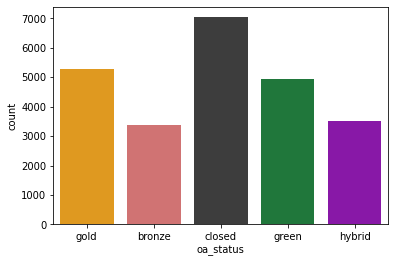

In [24]:
oa_colours = {"closed": "#3d3d3d", "gold":"#ffa200", "green":"#118536", "hybrid": "#9600bf", "bronze": "#e06363"}
ax = sns.countplot(data = df, x = "oa_status", palette = oa_colours)

count_oa = df.oa_status.value_counts(dropna=True)
percentage_oa = df.oa_status.value_counts(dropna=True, normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([count_oa,percentage_oa], axis=1, keys=['counts', '%'])

## Number of authors and Open Access status


In [ ]:
df['author_list'] = df["author_list"].apply(literal_eval)
df["num_authors"] = df['author_list'].apply(lambda x: len(list(x)))

[Text(0.5, 1.0, 'Number of authors per paper, by Open Access status')]

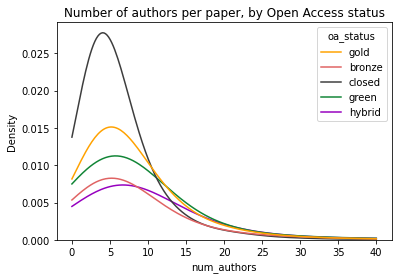

In [45]:
sns.kdeplot(
    data = df, x="num_authors", hue = "oa_status",  
    palette = oa_colours, clip = [0,40]).set(
    title='Number of authors per paper, by Open Access status')


Closed access papers were more likely to have a lower number of authors.

## Institutional affiliation

Analysis of the institutional affiliation of the authors was difficult to do as organisations are not consistently named. Additionally there are many co-authored papers with individuals from organisations outside of the NHS. This is an important area of work for this project - entity recognition and perhaps some kind of authority control list for reference would be helpful.

In [ ]:
df["openalex_metadata"] =  df["openalex_metadata"].apply(literal_eval)

## MESH headings

In [47]:
# get concepts from OpenAlex metadata
df['concepts'] = df['openalex_metadata'].apply(lambda x: x.get('concepts', "NaN"))
def get_concepts(list_with_concepts):
  temp_list = []
  for i in list_with_concepts:
    if i['display_name'] not in temp_list:
      temp_list.append(i['display_name'])
  return temp_list
df['concepts'] = df['concepts'].apply(lambda x: get_concepts(x))

In [48]:
# major mesh headings only 

# get major mesh headings
df['major_mesh'] = df['openalex_metadata'].apply(lambda x: x.get('mesh', "NaN"))
def get_major_mesh(list_with_mesh):
  temp_list = []
  for topic_list in list_with_mesh:
    if topic_list['is_major_topic'] == True:
      if topic_list['descriptor_name'] not in temp_list:
        temp_list.append(topic_list['descriptor_name'])
  return temp_list
df['major_mesh'] = df['major_mesh'].apply(lambda x: get_major_mesh(x))

for i in range(df.shape[0]):
  if len(df.major_mesh.iloc[i]) == 0:
    df.major_mesh.iloc[i] = df.concepts.iloc[i]

df['major_mesh'].apply(lambda x: list(set(x)))


# count number of occurences for topic
major_concept_count_dict = {}
for i in range(df.shape[0]):
  concept_list = df.major_mesh.iloc[i]
  for i in concept_list:
    if i not in major_concept_count_dict:
      major_concept_count_dict[i] = 1
    else: 
      major_concept_count_dict[i] += 1

## create df of concept counts only
major_concept_df = pd.DataFrame.from_dict(major_concept_count_dict, orient = "index", columns = ["count"])
major_concept_df.sort_values(by = 'count', inplace=True, ascending = False)
major_concept_df[major_concept_df['count'] >= 50]

# remove not useful subject headings
major_concept_df.drop(['Medicine', 'Internal medicine', 'MEDLINE',  'Disease'] ,inplace = True)

/tmp/ipykernel_2256/3663573514.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.major_mesh.iloc[i] = df.concepts.iloc[i]


The table below shows the count of the most frequently occuring MESH Major topics or OpenAlex concepts. Topics that were very general, such as 'Medicine', 'Internal medicine', 'MEDLINE', and 'Disease' were dropped.

Further analysis could map the frequently occuring MESH Major topics with the OpenAccess status for their corresponding papers, to see if specific topics were more likely to be OpenAccess, or not.

In [49]:
major_concept_df.iloc[:10]

,count
Surgery,612
Psychology,521
Intensive care medicine,398
Radiology,357
Magnetic Resonance Imaging,335
Quality of Life,325
Breast Neoplasms,311
Postoperative Complications,289
Neoplasms,284
Prostatic Neoplasms,274


# Next steps
